In [1]:
import numpy
import scipy
from matplotlib import pyplot
from matplotlib import patches
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from scipy.special import gamma, kv

In [74]:
def sqexp_kernel_func(x1, x2, l):
    """
    Calculate squared exponential kernel function at points x1, x2
    
    Args
    ----
    x1: array of length num_x1
    x2: array of length num_x2
    l: scale parameter for exponential kernel
    
    Returns
    ----
    k: num_x1 x num_x2 matrix of covariances
    """
    dx = (x1.reshape(-1, 1) - x2.reshape(1, -1)) / (l * numpy.sqrt(2.0))
    return numpy.exp(- dx ** 2)

def matern_kernel_func(x1, x2, l, v):
    """
    Calculate Matern kernel function at points x1, x2
    
    Args
    ----
    x1: array of length num_x1
    x2: array of length num_x2
    l: scale parameter for exponential kernel
    
    Returns
    ----
    k: num_x1 x num_x2 matrix of covariances
    """
    dx = (numpy.sqrt(2.0 * v) / l) * numpy.abs(x1.reshape(-1, 1) - x2.reshape(1, -1))
    c = (2 ** (1.0 - v)) / gamma(v)
    return numpy.where(dx == 0, 1.0, c * (dx ** v) * kv(v, dx))

In [11]:
def zero_mean(x):
    return numpy.zeros_like(x)

In [94]:
def sqrt_pos_semidef(m):
    try:
        r = numpy.linalg.cholesky(m)
    except numpy.linalg.LinAlgError:
        u, s, v = numpy.linalg.svd(m, hermitian=True)
        r = u @ numpy.diag(numpy.sqrt(s))
    return r

def draw_GP_samples(
        mean_vec,
        cov_mat,
        random_state=0,
        n_samples=1
):
    """
    Draw sample from GP prior given mean/cov functions

    Args
    ----
    mean_vec : 1D array, size n_grid_pts
        mean value of GP at each input x_i value 
    cov_mat : 2D matrix, n_grid_pts x n_grid_pts
        Covariance (kernel) matrix at each pair of inputs.
    random_state : int or numpy.random.RandomState
        Seed for the random number generator
    n_samples : int (default=1)
        Number of samples to draw from the prior

    Returns
    -------
    y_samples : 2D array, n_samples x n_grid_pts
        Contains sampled function values at each point of x_grid
    """
    if not isinstance(random_state, numpy.random.RandomState):
        random_state = numpy.random.RandomState(random_state)
    sqrt_k = sqrt_pos_semidef(cov_mat)
    
    return mean_vec.reshape(1, -1) + numpy.random.randn(n_samples, mean_vec.size) @ sqrt_k.transpose()

def draw_GP_posterior_samples_at_x_grid(
        x_grid,
        x_train, y_train,
        cov_func,
        random_state=0,
        n_samples=1,
):
    """
    Draw sample from GP posterior given training points and mean/cov functions

    Args
    ----
    x_grid: 1D array, size n_grid_pts
        Contains specific x_i values to evaluate function at
    x_train: 1D array, size n_train
        Contains x coordinates of observed values from gaussian process
    y_train: 1D array, size n_train
        Contains y coordinates of observed values from gaussian process
    cov_func : function, maps (1D arr size A, 1D arr size B) to (2D AxB)
        Computes covariance (kernel) value at each pair of inputs.
    random_state : int or numpy.random.RandomState
        Seed for the random number generator
    n_samples : int (default=1)
        Number of samples to draw from the prior

    Returns
    -------
    y_samples : 2D array, n_samples x n_grid_pts
        Contains sampled function values at each point of x_grid
    """
    cross_cov = cov_func(x_grid, x_train)
    inv_train_cov = numpy.linalg.pinv(cov_func(x_train, x_train))
    mean_posterior = (cross_cov @ (inv_train_cov @ y_train.reshape(-1, 1))).transpose()
    cov_posterior = cov_func(x_grid, x_grid) - cross_cov @ inv_train_cov @ cross_cov.transpose()

    return draw_GP_samples(mean_posterior, cov_posterior, random_state=random_state, n_samples=n_samples)

<IPython.core.display.Javascript object>


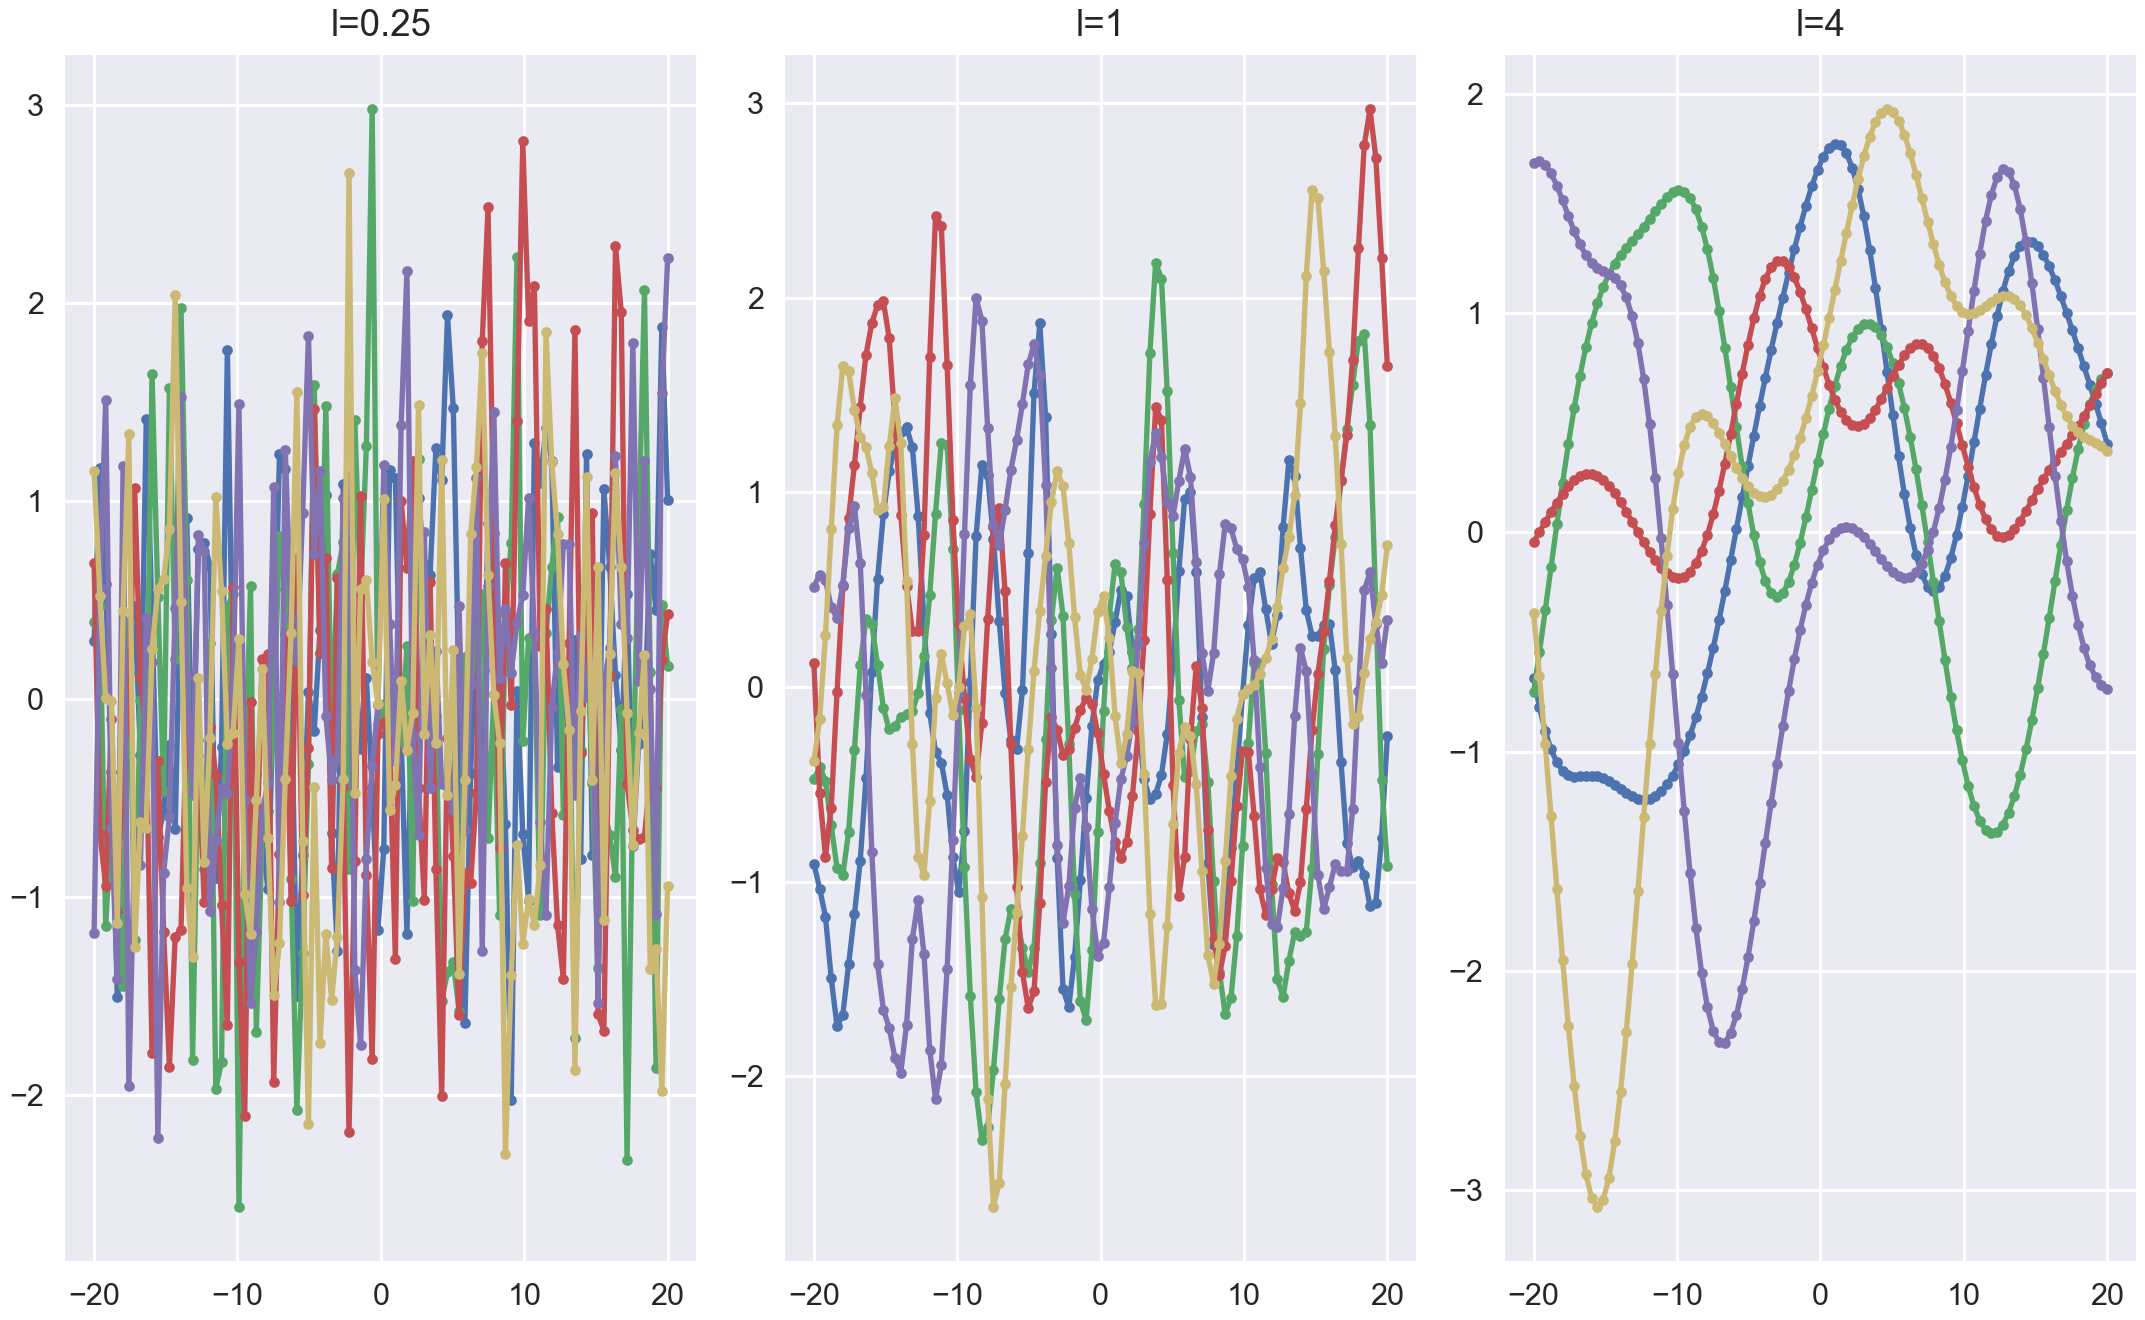

In [98]:
def problem_1a(x_range=(-20, 20), num_x=100, l_values=(0.25, 1.0, 4.0), random_state=0, n_samples=5):
    num_l = len(l_values)
    x_grid = numpy.linspace(*x_range, num_x)
    fig = pyplot.figure(num=1, constrained_layout=True)
    gridspec = fig.add_gridspec(1, num_l)
    mean_vec = zero_mean(x_grid)
    for col, l in enumerate(l_values):
        cov_mat = sqexp_kernel_func(x_grid, x_grid, l)
        y = draw_GP_samples(mean_vec, cov_mat, random_state=random_state, n_samples=n_samples)
        ax = fig.add_subplot(gridspec[0, col])
        ax.plot(x_grid, y.transpose(), ".-")
        ax.set_title("l=%g" % l)


problem_1a()

<IPython.core.display.Javascript object>


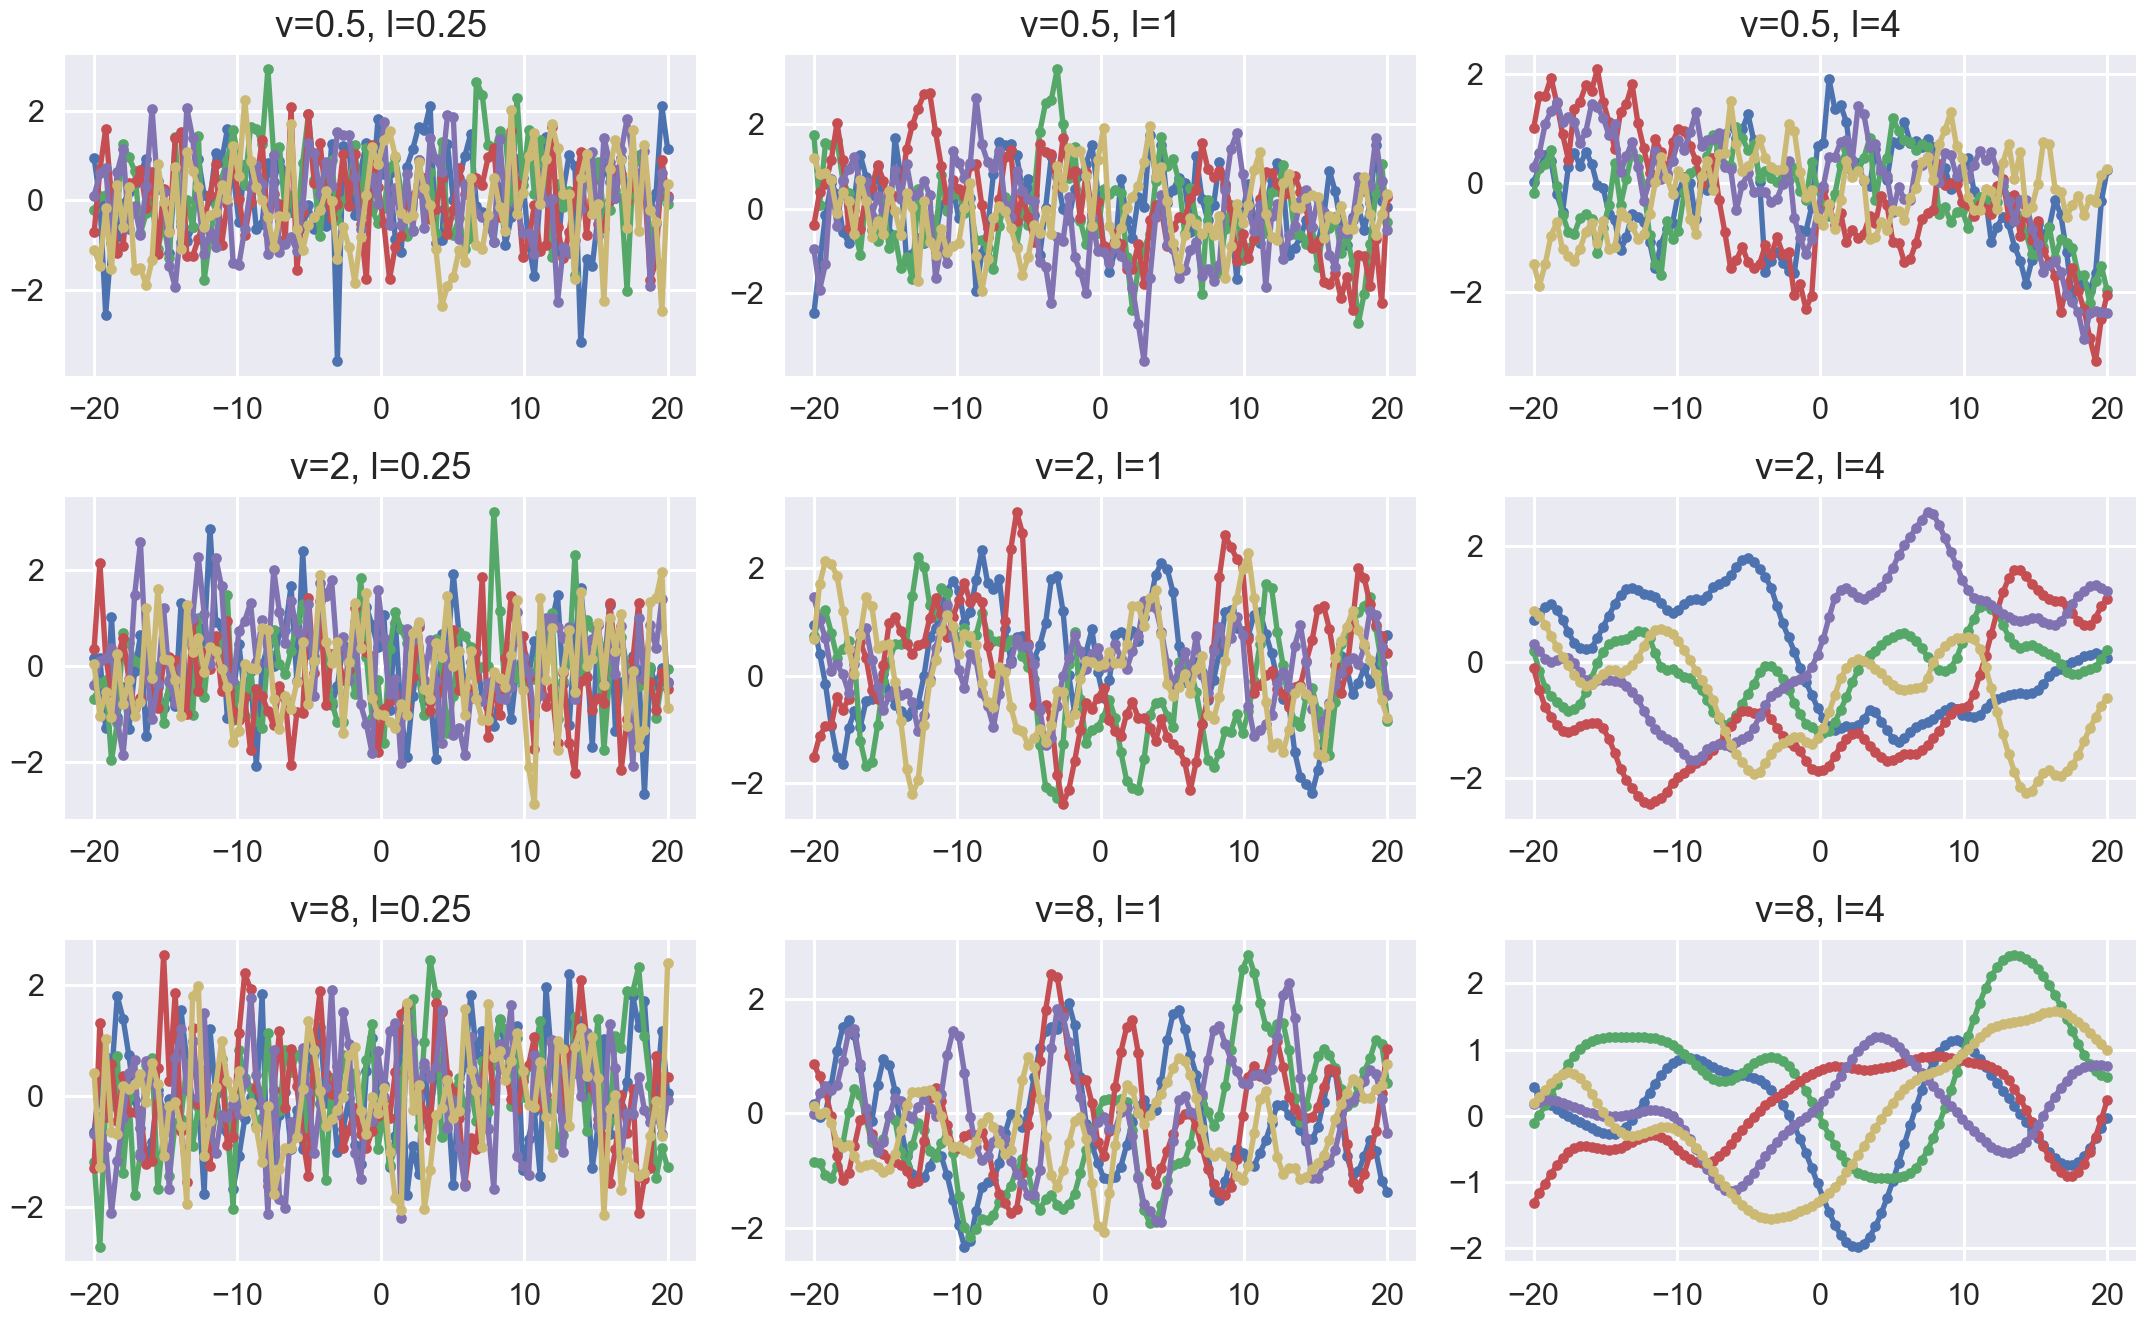

/Users/tbrookin/miniconda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


In [91]:
def problem_1c(x_range=(-20, 20), num_x=100, l_values=(0.25, 1.0, 4.0), v_values=(0.5, 2.0, 8.0),
               random_state=0, n_samples=5):
    num_l = len(l_values)
    num_v = len(v_values)
    x_grid = numpy.linspace(*x_range, num_x)
    fig = pyplot.figure(num=2, constrained_layout=True)
    gridspec = fig.add_gridspec(num_v, num_l)
    mean_vec = zero_mean(x_grid)
    for row, v in enumerate(v_values):
        for col, l in enumerate(l_values):
            cov_mat = matern_kernel_func(x_grid, x_grid, l, v)
            y = draw_GP_samples(mean_vec, cov_mat, random_state=random_state, n_samples=n_samples)
            ax = fig.add_subplot(gridspec[row, col])
            ax.plot(x_grid, y.transpose(), ".-")
            ax.set_title("v=%g, l=%g" % (v, l))

problem_1c()

<IPython.core.display.Javascript object>


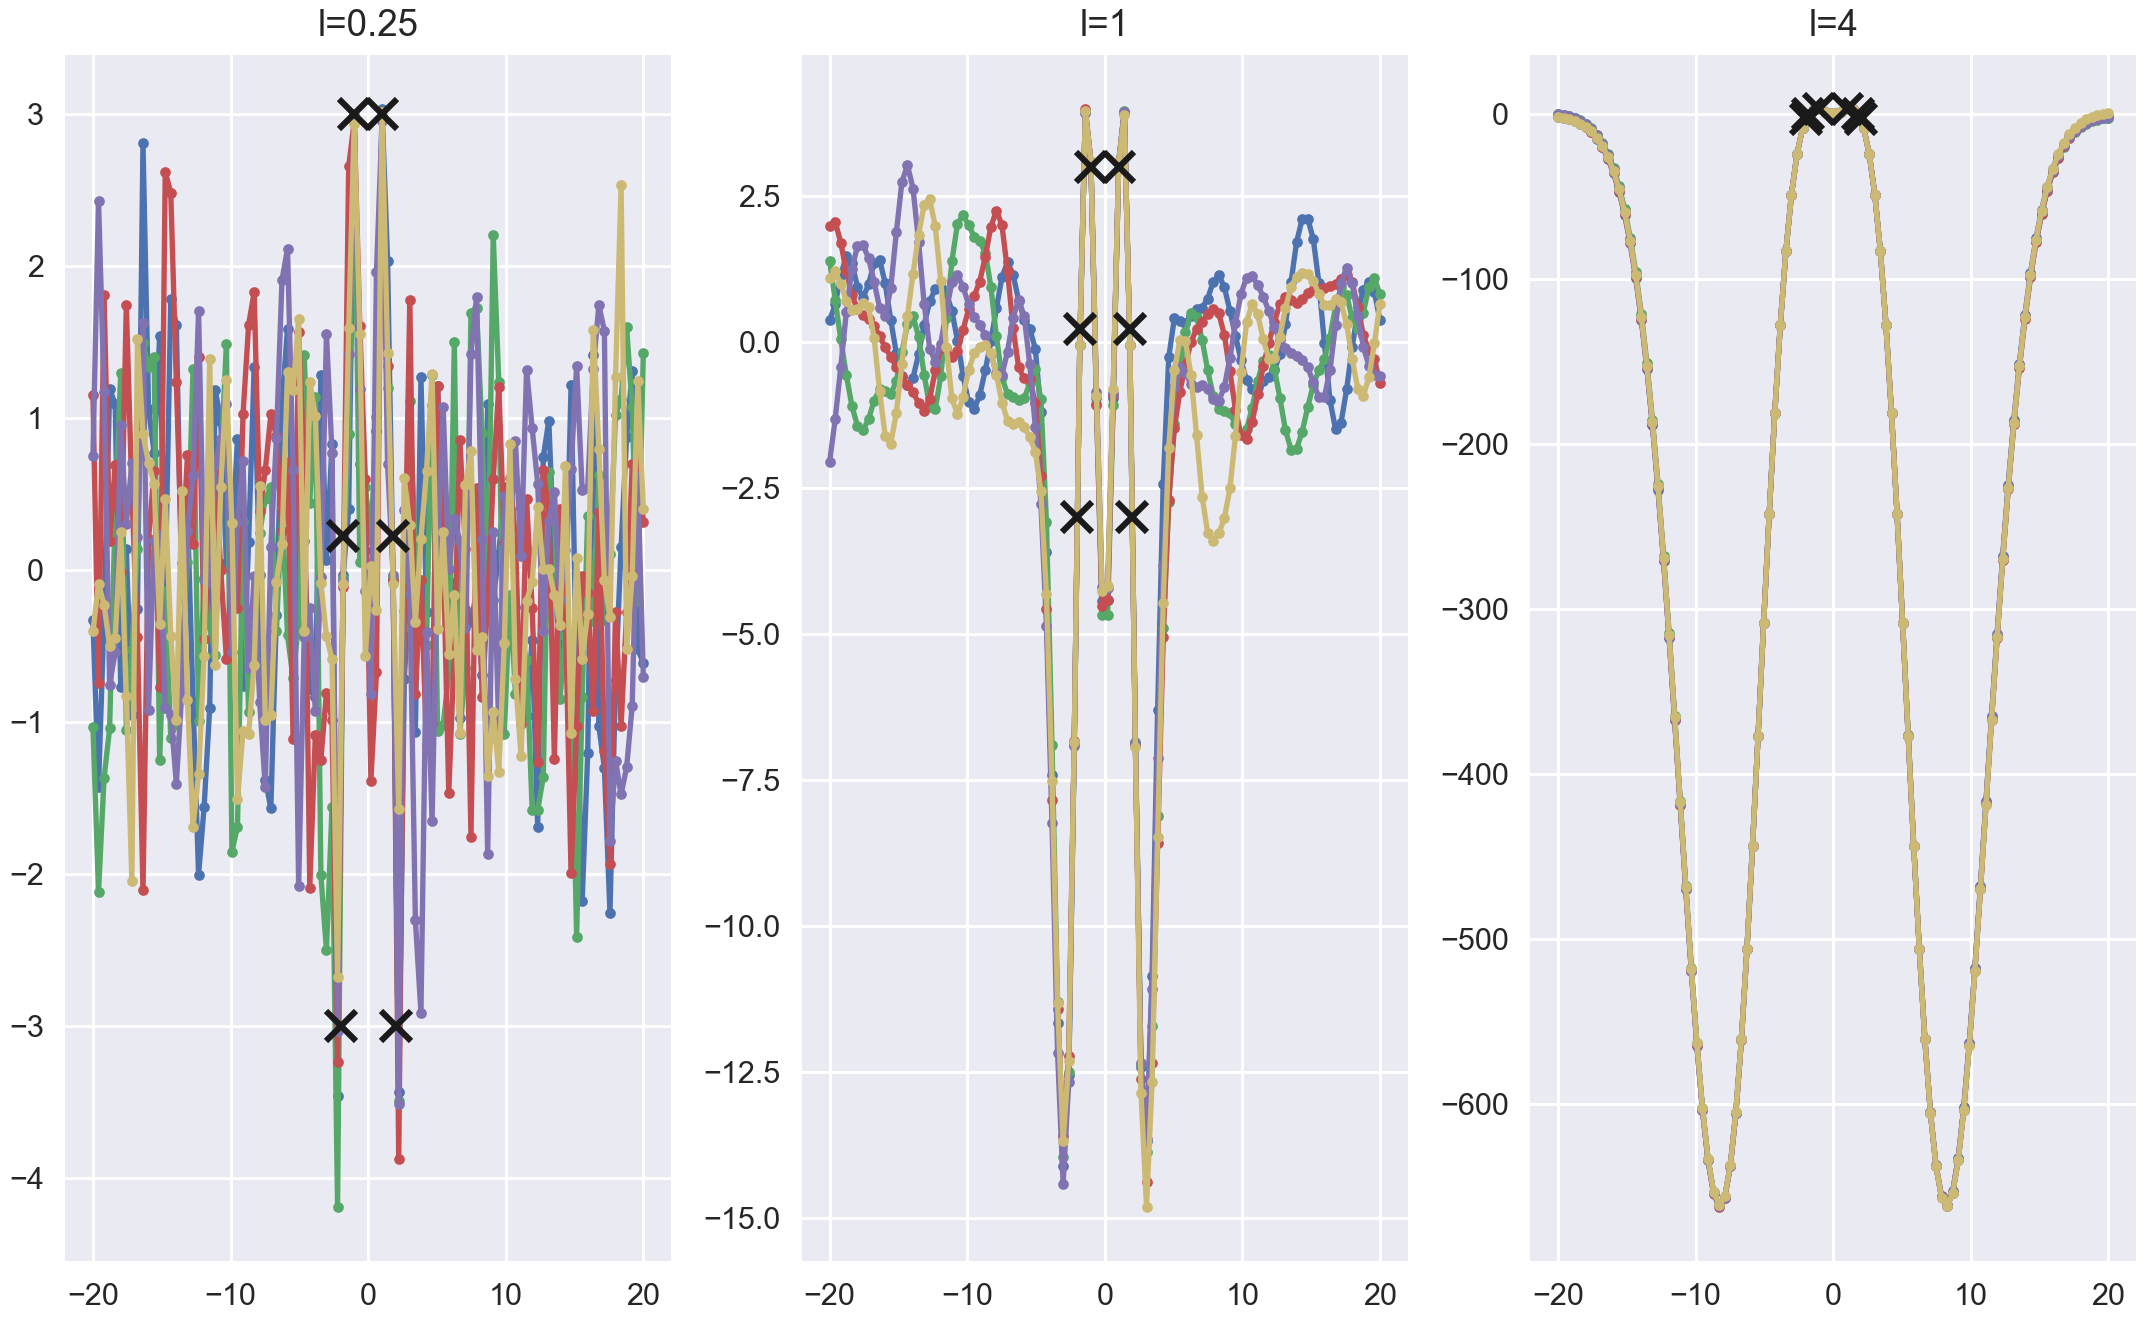

In [107]:
def problem_2a(
    x_range=(-20, 20), num_x=100, l_values=(0.25, 1.0, 4.0),
    random_state=0, n_samples=5,
    x_train = numpy.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.]),
    y_train = numpy.asarray([-3.,  0.2224,    3.,  3.,  0.2224, -3.])
):
    num_l = len(l_values)
    x_grid = numpy.linspace(*x_range, num_x)
    fig = pyplot.figure(num=3, constrained_layout=True)
    gridspec = fig.add_gridspec(1, num_l)
    for col, l in enumerate(l_values):
        cov_func = lambda _x, _y: sqexp_kernel_func(_x, _y, l)
        y = draw_GP_posterior_samples_at_x_grid(x_grid, x_train, y_train, cov_func,
                                                random_state=random_state, n_samples=n_samples)
        ax = fig.add_subplot(gridspec[0, col])
        ax.plot(x_grid, y.transpose(), ".-")
        ax.plot(x_train, y_train, "x", markeredgecolor="k", markerfacecolor="k",
                markeredgewidth=2, markersize=10)
        ax.set_title("l=%g" % l)

problem_2a()

<IPython.core.display.Javascript object>


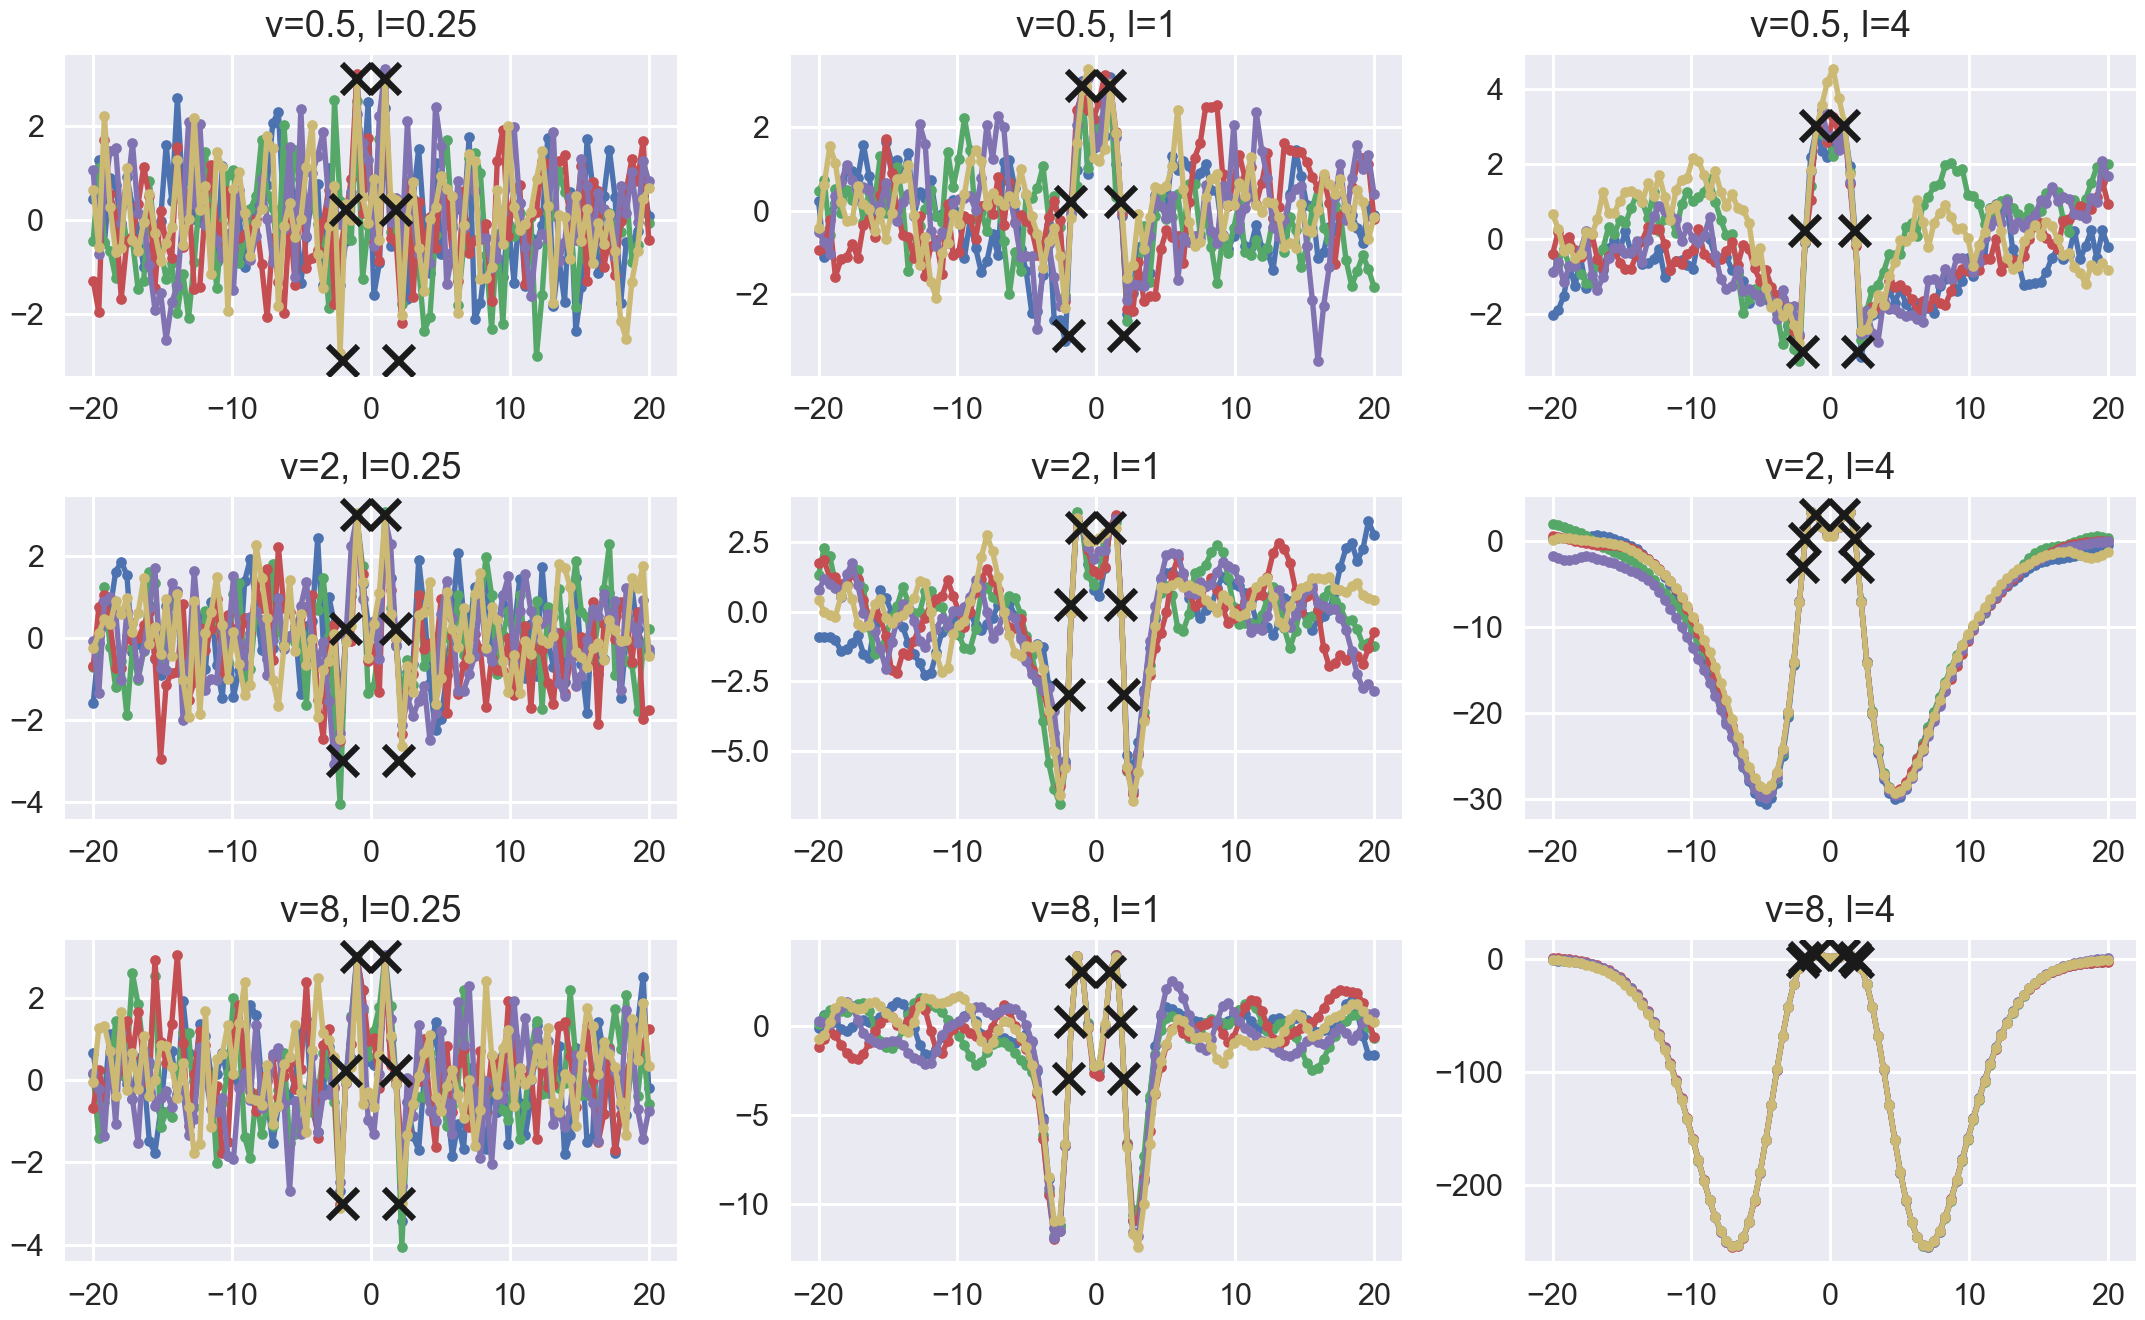

/Users/tbrookin/miniconda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


In [109]:
def problem_2c(
    x_range=(-20, 20), num_x=100, l_values=(0.25, 1.0, 4.0), v_values=(0.5, 2.0, 8.0),
    random_state=0, n_samples=5,
    x_train = numpy.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.]),
    y_train = numpy.asarray([-3.,  0.2224,    3.,  3.,  0.2224, -3.])
):
    num_l = len(l_values)
    num_v = len(v_values)
    x_grid = numpy.linspace(*x_range, num_x)
    fig = pyplot.figure(num=4, constrained_layout=True)
    gridspec = fig.add_gridspec(num_v, num_l)
    for row, v in enumerate(v_values):
        for col, l in enumerate(l_values):
            cov_func = lambda _x, _y: matern_kernel_func(_x, _y, l, v)
            y = draw_GP_posterior_samples_at_x_grid(x_grid, x_train, y_train, cov_func,
                                                    random_state=random_state, n_samples=n_samples)
            ax = fig.add_subplot(gridspec[row, col])
            ax.plot(x_grid, y.transpose(), ".-")
            ax.plot(x_train, y_train, "x", markeredgecolor="k", markerfacecolor="k",
                    markeredgewidth=2, markersize=10)
            ax.set_title("v=%g, l=%g" % (v, l))

problem_2c()